## Using H1 fullsim as input

Setup for benchmarking, laptop vs GPU

Trying out things from Ben Nachman's example.

This uses the H1 fullsim MC as input.

Uses set of variables is E, pt, pz, Empz (redundant but useful?) for both HFS and electron as well as delta phi between HFS and electron.


This is the main NN training notebook.


Training target variable is log(x) or x





In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl



In [2]:


#has_gpu = False

has_gpu = True



#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
max_events = 1e9


learning_rate_setval = 1e-4
batch_size_setval = 128
max_epochs = 5000
dropout_setval = 0.0



In [3]:
%%time


input_file = 'h1-fullsim-2021-07-19/h1-fullsim-allfiles.root'

ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['Django/minitree']
print(ur_tree)
ur_tree.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['gene_px','gene_py','gene_pz',
     'e_px','e_py','e_pz',
     'HFS_px','HFS_py','HFS_pz','HFS_E',
     'gen_Q2',
     'gen_y',
     'Empz',
     'Q2_e','y_e',
     'Q2_da','y_da',
     'Q2_sigma','y_sigma',     
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )


[b'Django;1']
<TTree b'minitree' at 0x7f35d7ddf430>
wgt                        (no streamer)              asdtype('>f4')
y_e                        (no streamer)              asdtype('>f4')
Q2_e                       (no streamer)              asdtype('>f4')
y_sigma                    (no streamer)              asdtype('>f4')
Q2_sigma                   (no streamer)              asdtype('>f4')
y_esigma                   (no streamer)              asdtype('>f4')
Q2_esigma                  (no streamer)              asdtype('>f4')
y_da                       (no streamer)              asdtype('>f4')
Q2_da                      (no streamer)              asdtype('>f4')
y_h                        (no streamer)              asdtype('>f4')
Q2_h                       (no streamer)              asdtype('>f4')
gen_x                      (no streamer)              asdtype('>f4')
gen_y                      (no streamer)              asdtype('>f4')
gen_Q2                     (no streamer)           

In [4]:
pandas_df

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,gen_Q2,gen_y,Empz,Q2_e,y_e,Q2_da,y_da,Q2_sigma,y_sigma
entry,,,,,,,,,,,,,,,,,,,
0,3.283574,5.129409,-10.929905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.343498,0.575322,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-5.531697,-3.367322,-2.631080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240.616425,0.841318,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.093026,7.108931,-14.778481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.483292,0.434525,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.031961,6.385868,-22.624577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.741684,0.158043,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-8.811806,6.074530,-17.640022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.209030,0.303108,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71659617,3.081678,-5.349218,-11.875680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.282341,0.523204,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71659618,0.689443,-4.239676,-5.899386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.173737,0.760921,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71659619,21.277891,0.579873,-19.101971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,524.301025,0.135840,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
n_before_empz = pandas_df.shape[0]
pandas_df = pandas_df.query('Empz>0')
n_after_empz = pandas_df.shape[0]
frac_after_empz = n_after_empz / n_before_empz
print('\n Fraction passing Empz>0 :  %d / %d = %8.4f' % (n_after_empz, n_before_empz, frac_after_empz))


 Fraction passing Empz>0 :  19615706 / 71659622 =   0.2737


In [6]:
pandas_df

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,gen_Q2,gen_y,Empz,Q2_e,y_e,Q2_da,y_da,Q2_sigma,y_sigma
entry,,,,,,,,,,,,,,,,,,,
9,7.991641,41.257713,-8.253663,7.896643,40.699341,-8.267031,-8.369857,-41.172997,234.253250,239.119141,1908.471558,0.074625,55.407475,1877.214722,0.084392,1872.364868,0.086757,1884.270386,0.087820
13,16.607563,7.054676,-2.758050,17.386559,7.380891,-3.096447,-12.415076,-13.259241,243.888321,280.390930,855.343079,0.619355,58.739544,885.630615,0.597157,812.146057,0.630583,942.419250,0.621432
20,-16.871563,29.083319,-11.572786,-16.517221,28.493423,-11.005733,3.738783,-14.740218,116.293289,119.632317,1324.020386,0.121437,49.227589,1309.299072,0.171546,1364.621338,0.136541,1163.892822,0.068047
21,5.742672,-13.619509,-19.351875,5.832151,-13.807648,-19.644226,-6.197764,15.308520,78.376953,82.877342,275.943939,0.070863,48.854145,279.604614,0.196490,318.636963,0.084321,247.460953,0.092119
22,-38.008579,-59.328259,127.920113,-35.669365,-56.400394,122.574600,36.352924,56.511467,56.111095,90.331985,15122.667969,0.671715,51.219391,14469.998047,0.692239,15669.503906,0.666726,13423.892578,0.668255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71659595,3.565408,9.880897,-17.109852,3.444457,9.806575,-16.737846,-2.923073,-11.384615,52.507603,71.962334,163.793930,0.326327,55.895081,163.649155,0.339849,168.395752,0.320701,165.709808,0.348058
71659596,-10.659201,6.177434,-22.454655,-9.979783,5.765417,-20.850082,7.264056,-1.912248,103.762489,104.141441,174.302917,0.012711,45.129658,164.135971,0.190695,200.205261,0.012849,133.962921,0.008411
71659599,-3.849821,-8.636397,-11.428583,-3.554196,-7.991180,-10.580326,1.953893,7.818446,33.963455,58.562283,187.929565,0.524244,48.906300,173.704529,0.559647,187.997131,0.523415,153.899399,0.502979


In [7]:
%%time

pandas_df.eval( 'gene_e = sqrt( gene_px*gene_px + gene_py*gene_py + gene_pz*gene_pz)', inplace=True )

pandas_df.eval( 'e_e = sqrt( e_px*e_px + e_py*e_py + e_pz*e_pz)', inplace=True )

pandas_df.eval( 'e_pt = sqrt( e_px*e_px + e_py*e_py)', inplace=True )

pandas_df.eval( 'e_phi = arctan2( e_py, e_px )', inplace=True )

pandas_df.eval( 'gene_pt = sqrt( gene_px*gene_px + gene_py*gene_py)', inplace=True )
pandas_df.eval( 'gene_phi = arctan2( gene_py, gene_px )', inplace=True )

pandas_df.eval( 'HFS_phi = arctan2( HFS_py, HFS_px )', inplace=True )
pandas_df.eval( 'HFS_pt = sqrt( HFS_px*HFS_px + HFS_py*HFS_py)', inplace=True )

pandas_df.eval( 'dphi = e_phi - HFS_phi', inplace=True )
pandas_df.eval( 'dphi = (abs(dphi)<3.14159265)*(dphi)+(dphi>3.14159265)*(dphi-2*3.14159265) + (dphi<-3.14159265)*(dphi+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi = (dphi>0)*dphi + (dphi<0)*(dphi+2*3.14159265)', inplace=True )


pandas_df.eval( 'gen_dphi = 3.141592653589793', inplace=True )

pandas_df.eval( 'HFS_Empz = HFS_E - HFS_pz', inplace=True )
pandas_df.eval( 'e_Empz = e_e - e_pz', inplace=True )

pandas_df.eval( 'gene_Empz = gene_e - gene_pz', inplace=True )

pandas_df.eval( 's = 4*27.6*920', inplace=True)
pandas_df.eval( 'gen_x = gen_Q2/(s*gen_y)', inplace=True)

pandas_df.eval( 'gen_log_x = log(gen_x)', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * HFS_pt - 0.70710678 * e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * HFS_pt + 0.70710678 * e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * HFS_Empz - 0.70710678 * e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * HFS_Empz + 0.70710678 * e_Empz', inplace=True )


CPU times: user 3.12 s, sys: 1.14 s, total: 4.26 s
Wall time: 1.55 s


## Do some cleaning

In [8]:
%%time

pandas_df = pandas_df.query('Empz>45')


pandas_df = pandas_df.query('gen_y > 0 and gen_y < 1.0')


CPU times: user 1.65 s, sys: 985 ms, total: 2.63 s
Wall time: 2.54 s


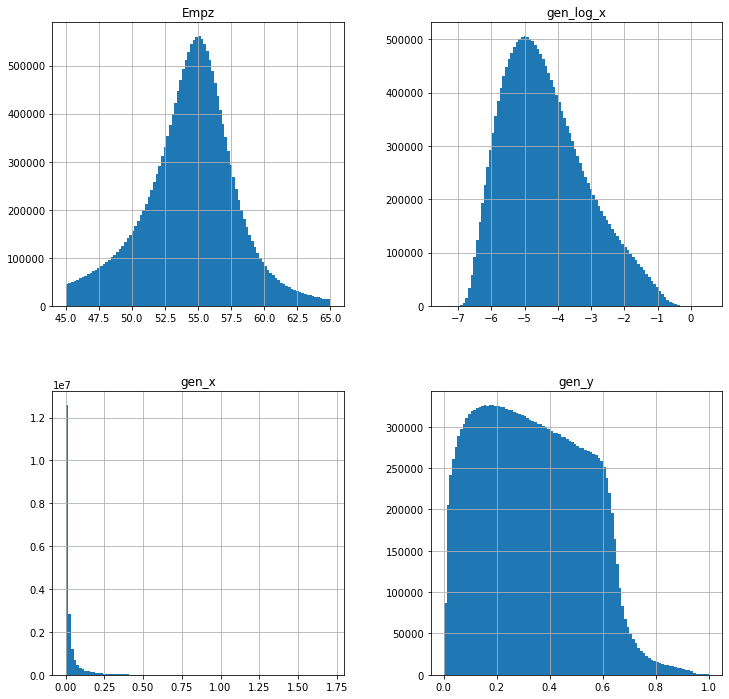

In [9]:
pandas_df.hist(figsize=(12,12), bins=100, column=['Empz','gen_y','gen_x','gen_log_x'])
plt.show()

In [10]:
pandas_df

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,...,HFS_Empz,e_Empz,gene_Empz,s,gen_x,gen_log_x,rot_pt1,rot_pt2,rot_Empz1,rot_Empz2
entry,,,,,,,,,,,,,,,,,,,,,
9,7.991641,41.257713,-8.253663,7.896643,40.699341,-8.267031,-8.369857,-41.172997,234.253250,239.119141,...,4.865891,50.541573,51.081085,101568.0,0.251793,-1.379150,0.393705,59.024643,-32.297585,39.178993
13,16.607563,7.054676,-2.758050,17.386559,7.380891,-3.096447,-12.415076,-13.259241,243.888321,280.390930,...,36.502609,22.236927,21.011444,101568.0,0.013597,-4.297904,-0.511988,26.200180,10.087359,41.535122
20,-16.871563,29.083319,-11.572786,-16.517221,28.493423,-11.005733,3.738783,-14.740218,116.293289,119.632317,...,3.339027,45.730652,47.131447,101568.0,0.107346,-2.231695,-12.535378,34.041309,-29.975403,34.697502
21,5.742672,-13.619509,-19.351875,5.832151,-13.807648,-19.644226,-6.197764,15.308520,78.376953,82.877342,...,4.500389,44.353752,43.702736,101568.0,0.038339,-3.261283,1.079546,22.276957,-28.180584,34.545094
22,-38.008579,-59.328259,127.920113,-35.669365,-56.400394,122.574600,36.352924,56.511467,56.111095,90.331985,...,34.220890,16.988434,18.121147,101568.0,0.221660,-1.506612,0.326149,94.701012,12.185186,36.210457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71659595,3.565408,9.880897,-17.109852,3.444457,9.806575,-16.737846,-2.923073,-11.384615,52.507603,71.962334,...,19.454731,36.440350,37.186985,101568.0,0.004942,-5.310020,0.961653,15.660851,-12.010646,39.523788
71659596,-10.659201,6.177434,-22.454655,-9.979783,5.765417,-20.850082,7.264056,-1.912248,103.762489,104.141441,...,0.378952,44.673645,48.066971,101568.0,0.135014,-2.002378,-2.838266,13.461185,-31.321077,31.856997
71659599,-3.849821,-8.636397,-11.428583,-3.554196,-7.991180,-10.580326,1.953893,7.818446,33.963455,58.562283,...,24.598827,24.307472,26.261688,101568.0,0.003529,-5.646618,-0.485806,11.882806,0.206018,34.581978


## Set up machine learning stuff

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#####physical_devices = tf.config.list_physical_devices('CPU') 




[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Now feed in reco electron and reco HFS

This includes a variable transformation that decorrelates pt and Empz between the HFS and the electron.

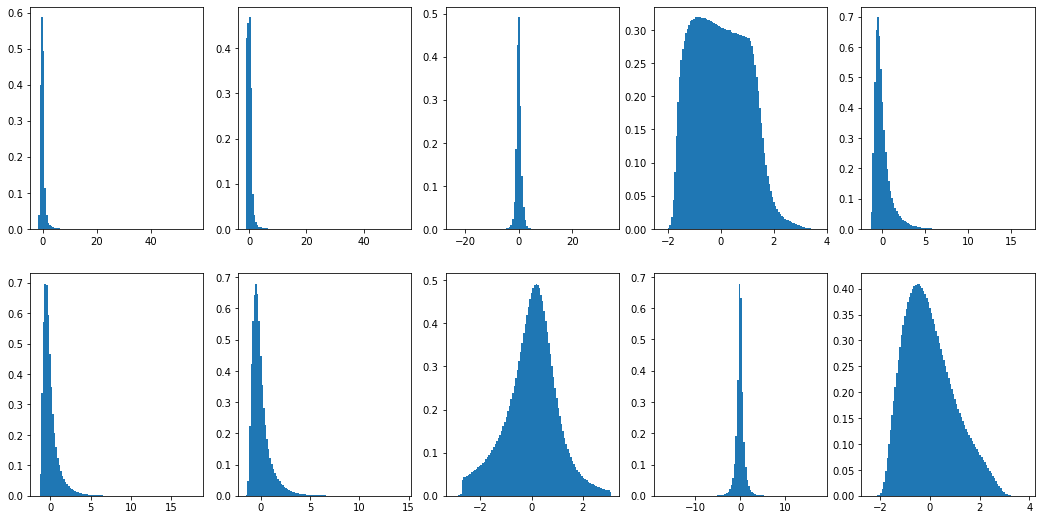

In [12]:
X3 = np.c_[ 
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['rot_pt1'].to_numpy(),
          pandas_df['rot_Empz1'].to_numpy(),
          pandas_df['HFS_pz'].to_numpy(),
          pandas_df['HFS_E'].to_numpy(),
          pandas_df['rot_pt2'].to_numpy(),
          pandas_df['rot_Empz2'].to_numpy(),
          pandas_df['dphi'].to_numpy(),
         ]

Y3 = pandas_df['gen_log_x'].to_numpy()

scaler3 = StandardScaler()
scaler3.fit(X3)
X3 = scaler3.transform(X3)

Y3 = Y3.reshape(-1,1)
scalerY3 = StandardScaler()
scalerY3.fit(Y3)
Y3 = scalerY3.transform(Y3)

GY3 = pandas_df['gen_y'].to_numpy()

X3_train, X3_test, Y3_train, Y3_test, GY3_train, GY3_test = train_test_split( X3, Y3, GY3, test_size=0.5)

fig,ax = plt.subplots(2,5,figsize=(18,9))
for i in range(5):
    ax[0][i].hist( X3[:,i],density=True,bins=100)
for i in range(4):
    ax[1][i].hist( X3[:,i+5],density=True,bins=100)

ax[1][4].hist( Y3[:,0],density=True,bins=100)
plt.show()

In [13]:
model3 = Sequential()

#-- initial layer
model3.add(Dense(64, input_dim=9, activation='relu'))
model3.add(Dropout(dropout_setval))



#-- middle part
model3.add(Dense(128, activation='selu'))
model3.add(Dropout(dropout_setval))
model3.add(Dense(512, activation='selu'))
model3.add(Dropout(dropout_setval))
model3.add(Dense(1024, activation='selu'))
model3.add(Dropout(dropout_setval))
model3.add(Dense(512, activation='selu'))
model3.add(Dropout(dropout_setval))
model3.add(Dense(128, activation='selu'))
model3.add(Dropout(dropout_setval))




#-- final layers
model3.add(Dense(64, activation='selu'))
model3.add(Dense(1, activation='linear'))



opt3 = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss3 = tf.keras.losses.Huber()

model3.compile(loss=myloss3, optimizer=opt3, metrics=['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [14]:
%%time

hist3 = model3.fit(
    X3_train, Y3_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X3_test,Y3_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
76562/76562 [==============================] - 222s 3ms/step - loss: 0.0090 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 1.0204e-07
Epoch 2/5000
76562/76562 [==============================] - 214s 3ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 1.0204e-07
Epoch 3/5000
76562/76562 [==============================] - 216s 3ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 1.0204e-07
Epoch 4/5000
76562/76562 [==============================] - 220s 3ms/step - loss: 0.0078 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 1.0204e-07
Epoch 5/5000
76562/76562 [==============================] - 215s 3ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 1.0204e-07
Epoch 6/5000
76562/76562 [==============================] - 217s 3ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 1.0204e-07
Epoch 7/5000
76562/76562 [==========================

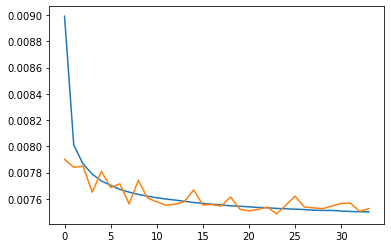

In [15]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

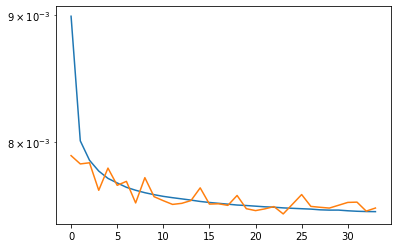

In [16]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.yscale('log')

In [17]:
tf.keras.models.save_model(model3,"model_output_h1_train_v1a")

INFO:tensorflow:Assets written to: model_output_h1_train_v1a/assets


In [18]:
mypreds3 = model3.predict(X3_test,batch_size=1000)

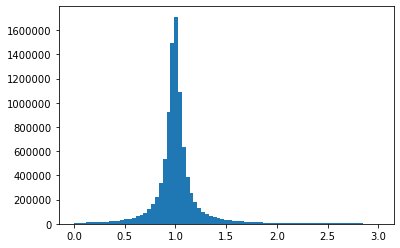

In [19]:
_,_,_=plt.hist(mypreds3[:,0]/Y3_test[:,0],bins=np.linspace(0,3,80))

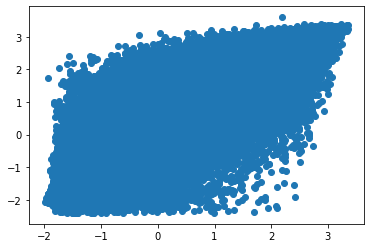

In [20]:
plt.scatter(mypreds3[:,0],Y3_test[:,0])

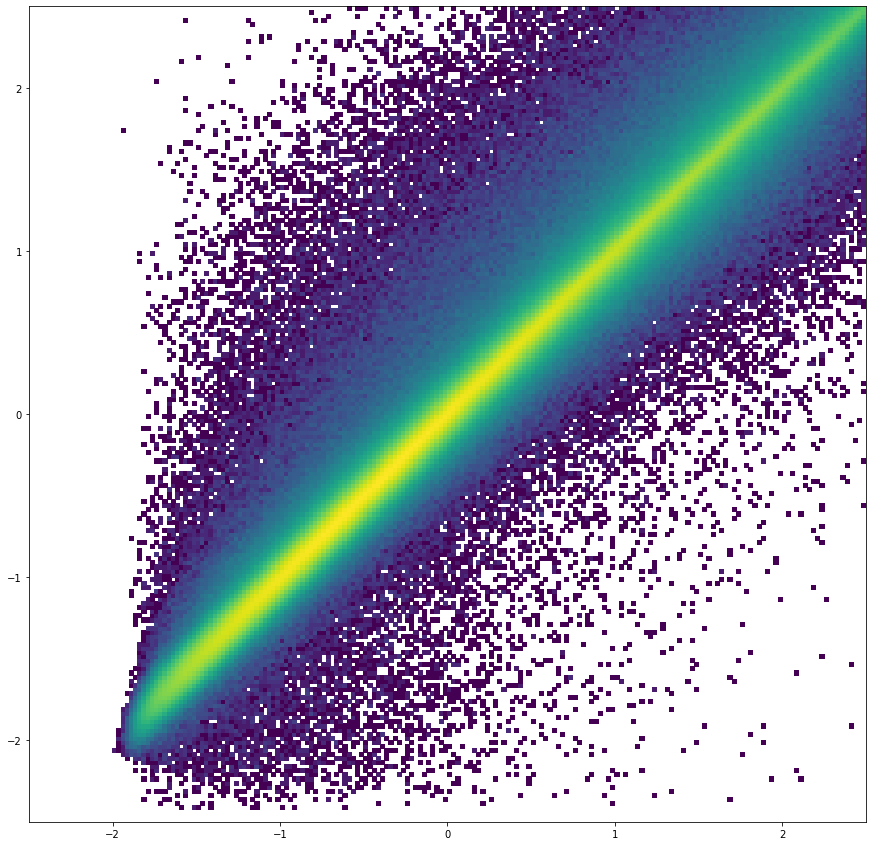

In [21]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds3[:,0],Y3_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

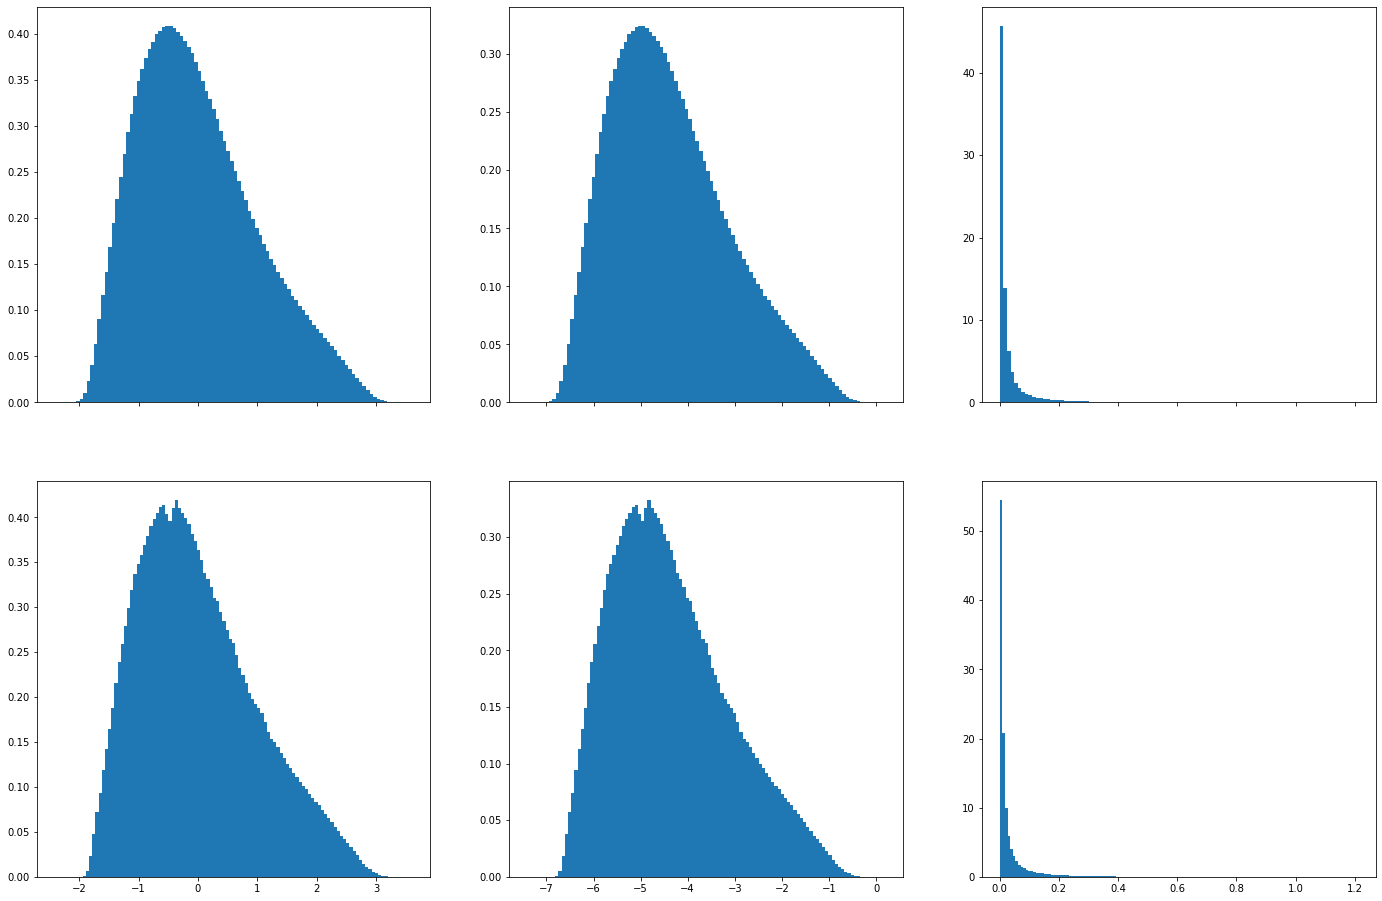

In [22]:
fig,ax = plt.subplots(2,3,figsize=(24,16), sharex='col')

ax[0][0].hist(Y3_test[:,0],density=True,bins=100)
ax[0][1].hist(scalerY3.inverse_transform(Y3_test)[:,0],density=True,bins=100)
ax[0][2].hist(np.exp(scalerY3.inverse_transform(Y3_test)[:,0]),density=True,bins=100)

ax[1][0].hist(mypreds3[:,0],density=True,bins=100)
ax[1][1].hist(scalerY3.inverse_transform(mypreds3)[:,0],density=True,bins=100)
ax[1][2].hist(np.exp(scalerY3.inverse_transform(mypreds3)[:,0]),density=True,bins=100)

plt.show()

## Plots of pred/true of training target variable : log(x)

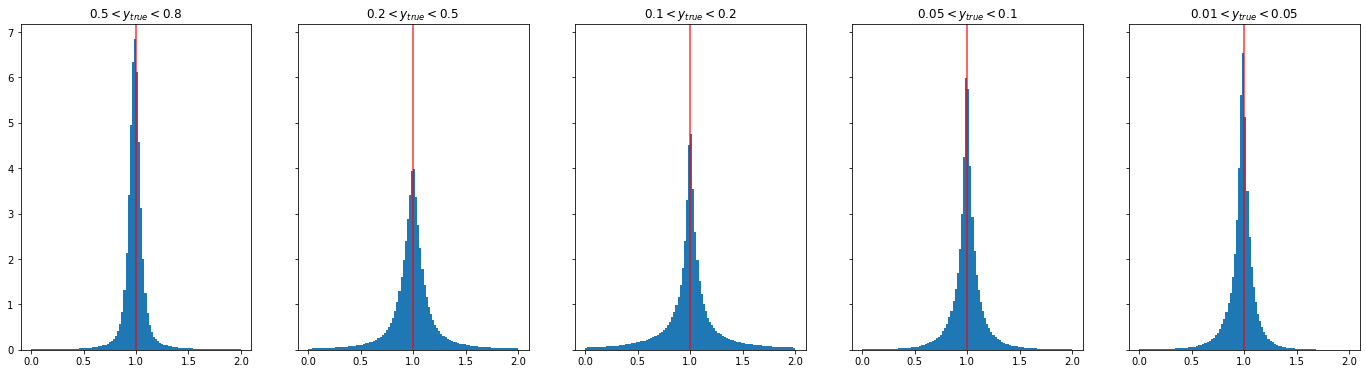

In [23]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()



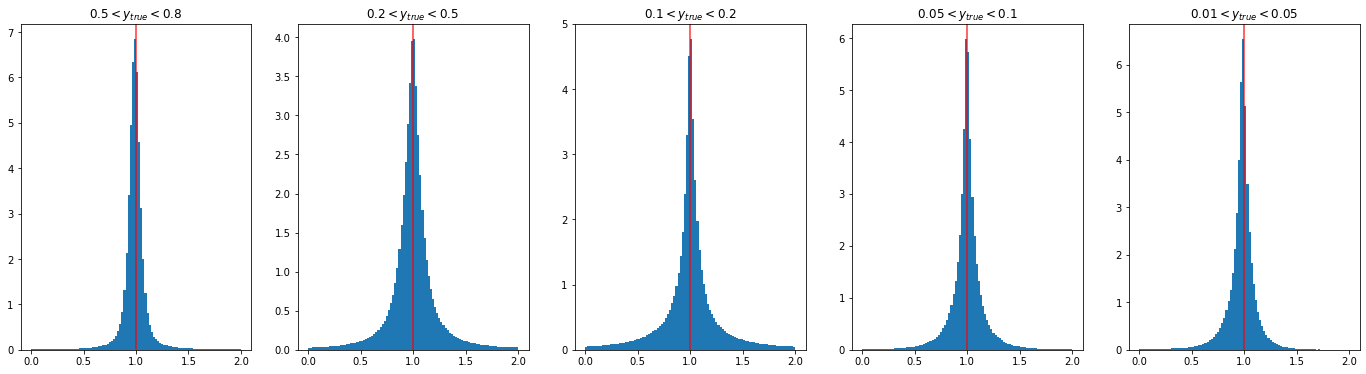

In [24]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

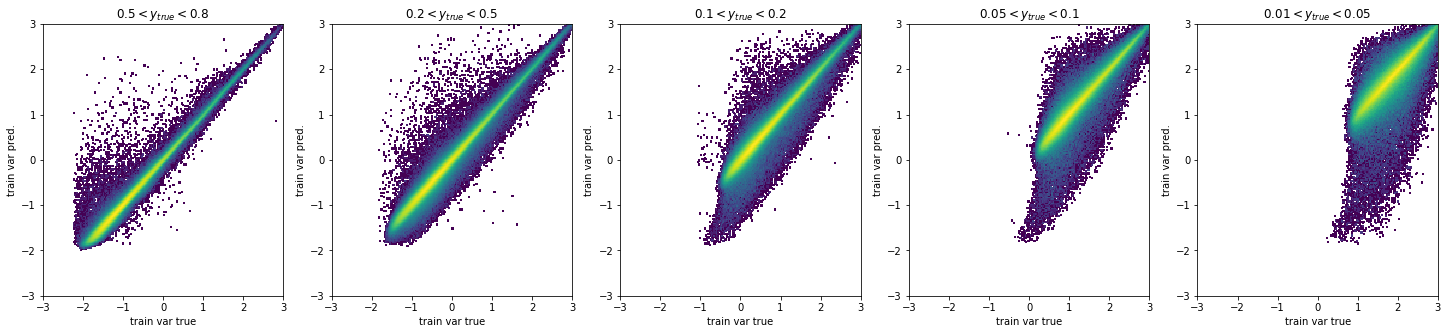

In [25]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],
              mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[1].hist2d( Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],
              mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[2].hist2d( Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],
              mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[3].hist2d( Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],
              mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[4].hist2d( Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],
              mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())





ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('train var pred.')
    ax[i].set_xlabel('train var true')


    
plt.show()

## Plots of predicted and true physics variable : x

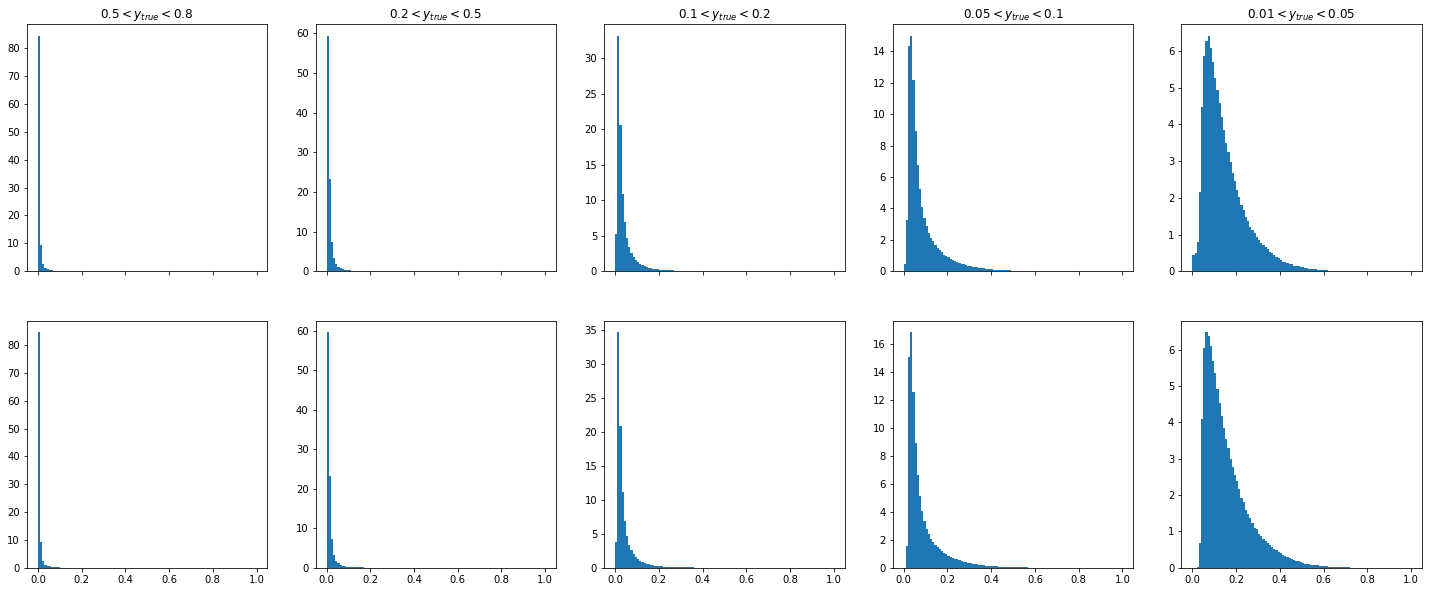

In [26]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,1))
ax[1][1].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,1))
ax[1][2].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,1))
ax[1][3].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,1))
ax[1][4].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

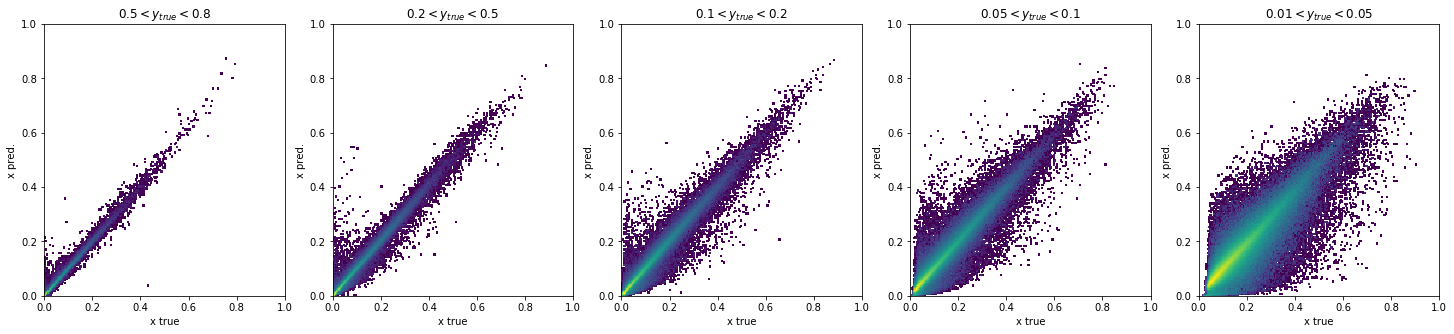

In [27]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())





ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of pred/true of physics variable:  x

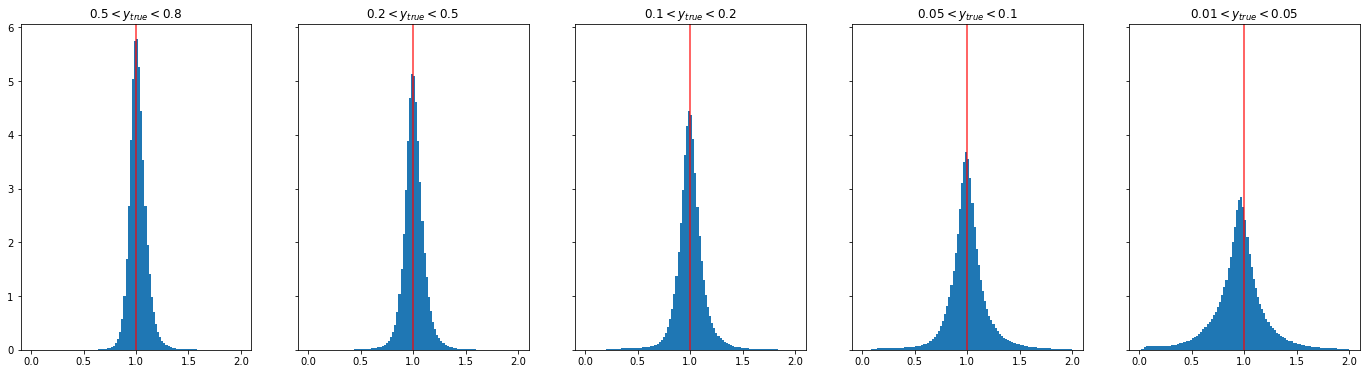

In [28]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Conclusions 

Deeper and larger network and higher training stats removes most of bias.


## Standard comparison plots

In [29]:

pandas_df.eval('s = 4*27.6*920', inplace=True)
pandas_df.eval('x_e = Q2_e/(s*y_e)',inplace=True)
pandas_df.eval('x_da = Q2_da/(s*y_da)',inplace=True)
pandas_df.eval('x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
pandas_df.eval('x_esigma = x_sigma',inplace=True)



pandas_df.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

pandas_df.eval('xe_ratio = x_e/gen_x',inplace=True)
pandas_df.eval('xda_ratio = x_da/gen_x',inplace=True)
pandas_df.eval('xsigma_ratio = x_sigma/gen_x',inplace=True)
pandas_df.eval('xesigma_ratio = x_esigma/gen_x',inplace=True)
        

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


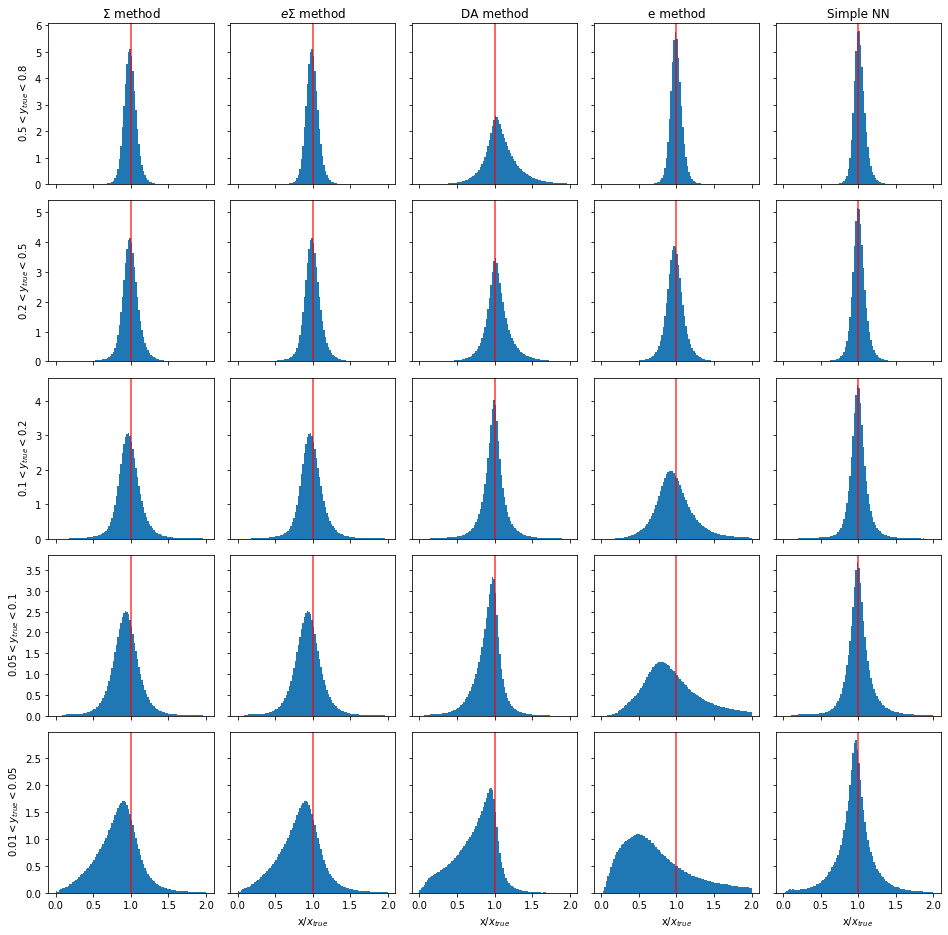

In [30]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)

xmin=0.
xmax=2.

for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['xsigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['xesigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['xda_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['xe_ratio'],density=True,bins=100,range=(xmin,xmax))

ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[9].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[14].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[19].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[24].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(xmin,xmax))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()

## Make standard plots with the x axis zoomed in more near 1.

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


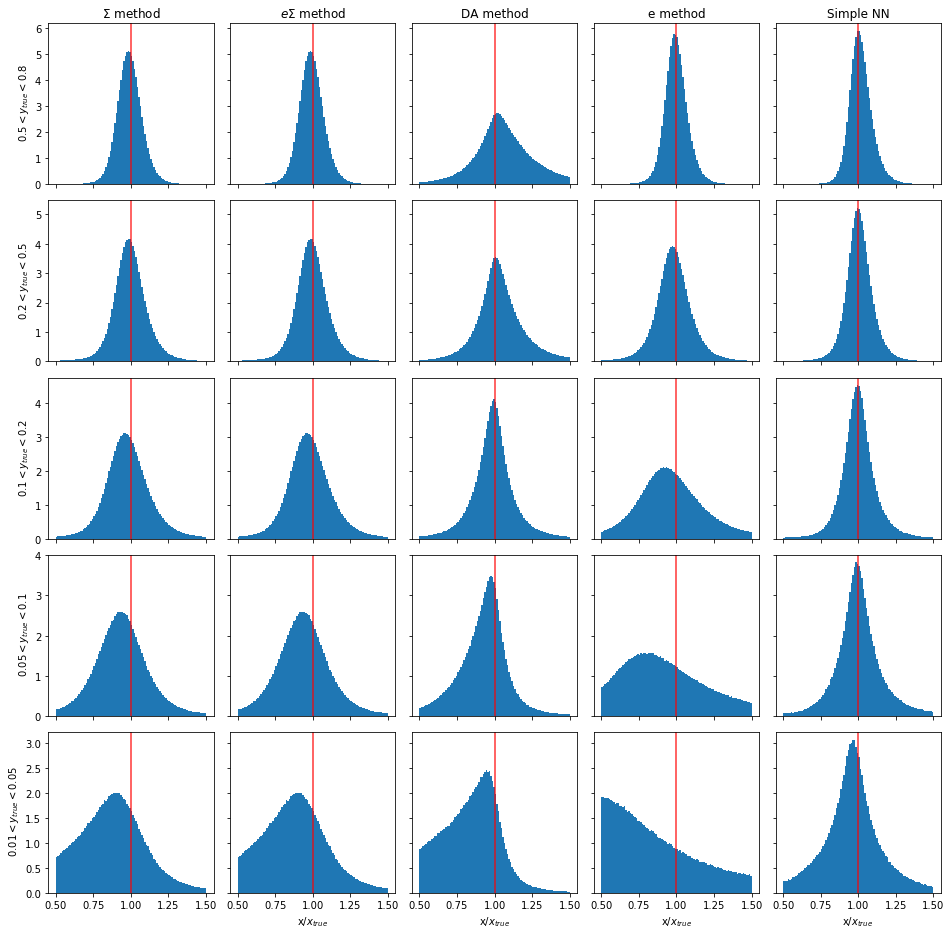

In [31]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)

xmin=0.5
xmax=1.5

for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['xsigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['xesigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['xda_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['xe_ratio'],density=True,bins=100,range=(xmin,xmax))

ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[9].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[14].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[19].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[24].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(xmin,xmax))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()